<h1 style='color:blue' align='center'>Athletes Image Classification<h1>

__The problem that we are going to solve here is that there is a data set of images which has been collected useing fatkun chrome extension.Our machine learning model must classify celebrity's image. To train our machine learning model with thise data set, we will try several classification algorithms.__

### Dataset information

_Sports person dataset contains 6941 images of 5 famous athletes.They are captain of the Armenian national football team Henrikh Mkhitaryan, Maria Sharapova the winner of five Grand Slam titles, armenian boxer Arthur Abraham who was IBF middleweight champion from 2005 to 2009, Serena Williams who won more Grand Slam singles titles (23) than any other woman or man during the open era and forward Cristiano Ronaldo  who is one of the greatest players of the history. Each has approximately the same number of images in the data set._

In [3]:
#Import libraries
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pywt
from skimage import io

<h3 style='color:purple'>1. Preprocessing: Detect face and eyes</h3>

__First we will use two test images doing face and eyes detection then we will apply same codes for the entire dataset.We will use haar cascade from opencv to detect face and eyes.__ 

In [7]:
# Read image
img = io.imread('./test_images/Sharapova.jpg')
img.shape

(200, 150, 3)

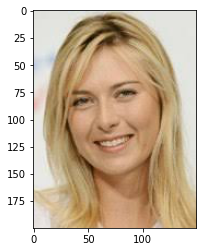

In [3]:
# Show image
plt.imshow(img)

In [4]:
# Convert color image into gray image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(200, 150)

In [5]:
gray

array([[222, 222, 222, ..., 226, 226, 226],
       [222, 222, 222, ..., 226, 226, 226],
       [222, 222, 222, ..., 226, 226, 226],
       ...,
       [226, 225, 225, ..., 152, 152, 153],
       [226, 226, 225, ..., 146, 149, 152],
       [229, 228, 227, ..., 146, 151, 154]], dtype=uint8)

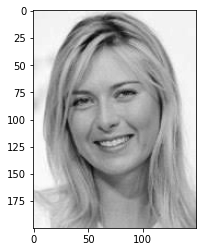

In [6]:
# Show black and white image
plt.imshow(gray, cmap='gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray)
faces

array([[ 18,  40, 103, 103]], dtype=int32)

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(18, 40, 103, 103)

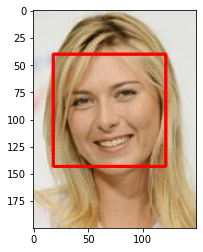

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

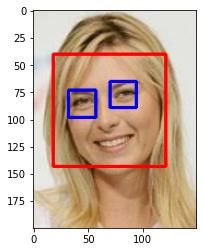

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,0,255),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

<h3 style='color:purple'>2. Preprocessing: Crop the facial region of the image</h3>

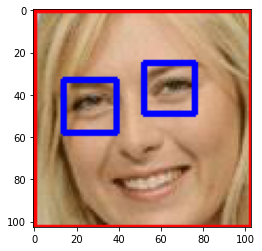

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
cropped_img = np.array(roi_color)
cropped_img.shape

(103, 103, 3)

<h3 style='color:purple'> 3. Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### Wavelet transform

In [13]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

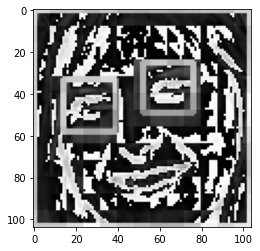

In [14]:
im_har = w2d(cropped_img,'db1', 3)
plt.imshow(im_har, cmap='gray')

<h3 style='color:purple'>3.  Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

In [15]:
# Function that can take input image and returns cropped image (if face and eyes >=2 are detected)
def get_cropped_image_if_2_eyes(image_path):
    img = io.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

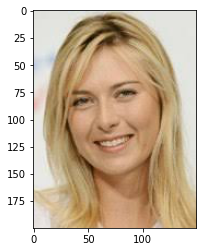

In [16]:
original_image = io.imread('./test_images/Sharapova.jpg')
plt.imshow(original_image)

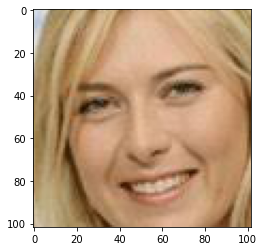

In [17]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/Sharapova.jpg')
plt.imshow(cropped_image)

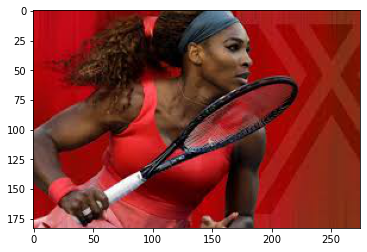

In [18]:
org_image_obstructed = io.imread('./test_images/williams.jpg')
plt.imshow(org_image_obstructed)

In [19]:
# In above image face is not very clear and it doesn't have two eyes clearly visible so the function will return None
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/williams.jpg')
cropped_image_no_2_eyes

#### Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training

In [28]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [29]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [30]:
img_dirs

['./dataset/Arthur_Abraham',
 './dataset/Cristiano_Ronaldo',
 './dataset/Henrikh_Mkhitaryan',
 './dataset/Maria_Sharapova',
 './dataset/Serena_Williams']

In [31]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [32]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1   

Arthur_Abraham
Generating cropped images in folder:  ./dataset/cropped/Arthur_Abraham
Cristiano_Ronaldo
Generating cropped images in folder:  ./dataset/cropped/Cristiano_Ronaldo
Henrikh_Mkhitaryan
Generating cropped images in folder:  ./dataset/cropped/Henrikh_Mkhitaryan
Maria_Sharapova
Generating cropped images in folder:  ./dataset/cropped/Maria_Sharapova
Serena_Williams
Generating cropped images in folder:  ./dataset/cropped/Serena_Williams


#### Manually examine cropped folder and delete any unwanted images

In [56]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Arthur_Abraham': ['./dataset/cropped/Arthur_Abraham\\Arthur_Abraham1.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham10.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham11.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham12.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham13.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham14.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham15.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham16.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham18.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham19.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham2.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham20.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham21.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham22.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham23.png',
  './dataset/cropped/Arthur_Abraham\\Arthur_Abraham24.png',
  './dataset/cropped/Art

In [57]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Arthur_Abraham': 0,
 'Cristiano_Ronaldo': 1,
 'Henrikh_Mkhitaryan': 2,
 'Maria_Sharapova': 3,
 'Serena_Williams': 4}

#### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [58]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',3)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [59]:
len(X[0])

4096

In [60]:
X[0]

array([[  8],
       [  9],
       [ 14],
       ...,
       [132],
       [  8],
       [ 22]], dtype=uint8)

In [61]:
y[0]

0

In [62]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(355, 4096)

### Data cleaning process is done. Now we are ready to train our model

In [63]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8426966292134831

In [65]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87        23
           1       0.78      0.78      0.78        18
           2       0.89      0.85      0.87        20
           3       0.90      0.78      0.84        23
           4       0.71      1.00      0.83         5

    accuracy                           0.84        89
   macro avg       0.83      0.86      0.84        89
weighted avg       0.85      0.84      0.84        89



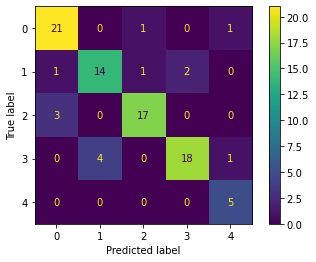

In [70]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe, X_test, y_test)  
plt.show()  

### Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [71]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [72]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}


In [73]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=10, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.826923,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.617094,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.853846,{'logisticregression__C': 1}


In [74]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [75]:
best_estimators['svm'].score(X_test,y_test)

0.8651685393258427

In [76]:
best_estimators['random_forest'].score(X_test,y_test)

0.7078651685393258

In [77]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7865168539325843

In [78]:
best_clf = best_estimators['svm']

In [89]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[18,  0,  0,  4,  1],
       [ 1, 16,  1,  0,  0],
       [ 1,  0, 19,  0,  0],
       [ 3,  1,  0, 19,  0],
       [ 0,  0,  0,  0,  5]], dtype=int64)

In [93]:
class_dict

{'Arthur_Abraham': 0,
 'Cristiano_Ronaldo': 1,
 'Henrikh_Mkhitaryan': 2,
 'Maria_Sharapova': 3,
 'Serena_Williams': 4}

[Text(0, 0.5, 'Arthur Abraham'),
 Text(0, 1.5, 'Cristiano Ronaldo'),
 Text(0, 2.5, 'Henrikh Mkhitaryan'),
 Text(0, 3.5, 'Maria Sharapova'),
 Text(0, 4.5, 'Serena Williams')]

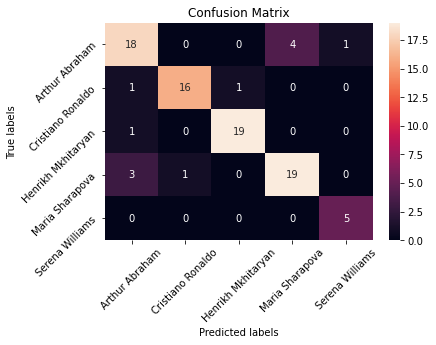

In [111]:
ax= plt.subplot()
sns.heatmap(cm, annot=True)  
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Arthur Abraham', 'Cristiano Ronaldo', 'Henrikh Mkhitaryan', 'Maria Sharapova','Serena Williams'],rotation=45)
ax.yaxis.set_ticklabels(['Arthur Abraham', 'Cristiano Ronaldo', 'Henrikh Mkhitaryan', 'Maria Sharapova','Serena Williams'],rotation=45)

### Save the trained model

In [109]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)


['saved_model.pkl']

### Save class dictionary

In [110]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

So In this notebook, we have built three classification models using the data set. These are Logistic regression, Random forest classifier and SVM . Afterward we have calculated the performance  of the models. Out of which SVM is the best suit for this dataset. 